In [169]:
import pandas as pd
import seaborn as sns

In [170]:
# read in data and take some initial looks
data = pd.read_csv('data/LoanStats3a.csv')

/var/folders/0w/pvg4kzqx7757341_gst5jz6h0000gp/T/ipykernel_44231/819498577.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/LoanStats3a.csv')


In [171]:
data.shape

(42538, 144)

In [172]:
TARGET_VAR = 'loan_status'

<Axes: xlabel='loan_status', ylabel='Count'>

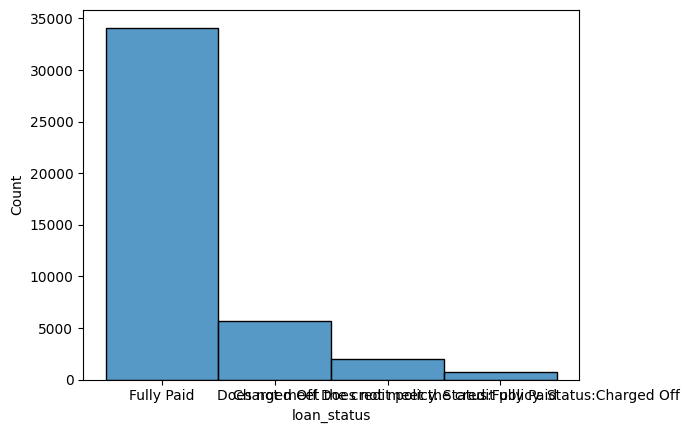

In [173]:
sns.histplot(data[TARGET_VAR])

Start by inspecting target variable. We are looking to determine whether or not the loan is expected to be paid off, so we can binarize these into "Fully Paid" and everything else. Let's inspect the data a bit more.

In [174]:
categorical_features = [x for x in data.dtypes.keys() if data.dtypes[x] == object]
numeric_features = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
print(f'CATEGORICALS: {len(categorical_features)}')
print(sorted(categorical_features))
print(f'NUMERIC: {len(numeric_features)}')
print(sorted(numeric_features))

CATEGORICALS: 29
['addr_state', 'application_type', 'debt_settlement_flag', 'debt_settlement_flag_date', 'desc', 'disbursement_method', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d', 'loan_status', 'next_pymnt_d', 'purpose', 'pymnt_plan', 'revol_util', 'settlement_date', 'settlement_status', 'sub_grade', 'term', 'title', 'verification_status', 'zip_code']
NUMERIC: 115
['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc', 'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'deferral_term', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'funded_amnt', 'funded_amnt_inv', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason'

In [175]:
for cat in categorical_features:
    print(cat.upper())
    print(data[cat].describe())

TERM
count          42535
unique             2
top        36 months
freq           31534
Name: term, dtype: object
INT_RATE
count      42535
unique       394
top       10.99%
freq         970
Name: int_rate, dtype: object
GRADE
count     42535
unique        7
top           B
freq      12389
Name: grade, dtype: object
SUB_GRADE
count     42535
unique       35
top          B3
freq       2997
Name: sub_grade, dtype: object
EMP_TITLE
count       39909
unique      30658
top       US Army
freq          139
Name: emp_title, dtype: object
EMP_LENGTH
count         41423
unique           11
top       10+ years
freq           9369
Name: emp_length, dtype: object
HOME_OWNERSHIP
count     42535
unique        5
top        RENT
freq      20181
Name: home_ownership, dtype: object
VERIFICATION_STATUS
count            42535
unique               3
top       Not Verified
freq             18758
Name: verification_status, dtype: object
ISSUE_D
count      42535
unique        55
top       Dec-11
freq        2

We have some categorical and many numeric features. After inspecting the data, we find that we need to convert some categoricals to either binary or numeric. We will one-hot-encode any categorical features that have only a small number of classes. Lastly, we'll drop any remaining features that have very few classes or are largely NaN. 

In [176]:
DROP = ['member_id'] # We will definitely drop member id, add more to this list as we go
# take only instances that aren't missing target var
data = data[data[TARGET_VAR].notna()].copy()
# replace NaN with 0
data.fillna(0, inplace=True)

# Convert target vars to 0 and 1
data['loan_status'] = data['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# convert Y/N to 0 and 1
data['debt_settlement_flag'] = data['debt_settlement_flag'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert percentage strings to floats
for var in ['revol_util', 'int_rate']:
    data[var] = data[var].apply(lambda x: float(str(x).replace('%', '')))

# Convert "N months" to int
data['term'] = data['term'].apply(lambda x: int(str(x).replace(' months', '')))

# Convert letter grade to numeric
letter_mapping = {n: i for i, n in enumerate(list('ABCDEFG'))}
data['grade'] = data['grade'].apply(lambda x: letter_mapping[x])

# Engineer some more features that could be helpful
data['diff_installment_last_pymnt'] = data['installment'] - data['last_pymnt_amnt'] # difference between monthly installent amount and amount paid
data['total_repayment_amnt'] = data['installment'] * data['term'] # total amount to be repaid
data['fund_amt_per_month'] = data['funded_amnt'] / data['term'] # amount loaned broken down by month

for f in data.columns:
    if data[f].value_counts().shape[0] == 1:
        DROP.append(f)

# and then a couple others that had very few classes or data was missing for the vast majority of instances
DROP.extend(
    [
        'tax_liens', 
        'delinq_amnt', 
        'settlement_date', 
        'debt_settlement_flag_date', 
        'settlement_status', 
        'verification_status'
    ]
)
# Next payment date seems irrelevant for predicting loan default
DROP.append('next_pymnt_d')

# Drop other categorical variables for now--we'll return to them later
DROP.extend(
    [
        'last_credit_pull_d', 
        'last_pymnt_d', 
        'earliest_cr_line', 
        'issue_d', 
        'desc',
        'home_ownership',
        'purpose',
        'settlement_status',
        'verification_status',
        'addr_state',
        'zip_code',
        'emp_length',
        'emp_title',
        'sub_grade',
        'title'
    ]
)

target = data[TARGET_VAR]
df = data.loc[:,list(set(data.columns) - set(DROP + [TARGET_VAR]))]

df.shape

(42535, 35)

Now let's try training the model so we can look at some residuals.

In [180]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report

X = df.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1611
           1       0.95      1.00      0.97      6896

    accuracy                           0.96      8507
   macro avg       0.96      0.89      0.92      8507
weighted avg       0.96      0.96      0.95      8507



/Users/ellynkeith/PycharmProjects/ML_AI/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy is excellent. Recall, not so much. Also, we had a convergence failure. Let's look at the residuals and some goodness-of-fit metrics to see if we can discover anything.

In [119]:
from sklearn.metrics import mean_squared_error
from scipy import stats
import numpy as np

def gof(residuals, y_pred, X, y):
    # Number of observations and number of predictors
    n = len(y)
    p = X.shape[1]

    # MSE
    mse = mean_squared_error(y, y_pred)

    # Chi-Square
    # Assuming homoscedastic residuals (normal distribution of errors)
    chi_square = np.sum((residuals ** 2) / y_pred)

    # AIC = 2k - 2ln(L)
    # Where k is the number of parameters (p + 1 for intercept)
    # L is the likelihood of the model
    rss = np.sum(residuals ** 2)
    sse = rss / n
    aic = n * np.log(sse) + 2 * (p + 1)

    # BIC = k * ln(n) - 2ln(L)
    bic = n * np.log(sse) + (p + 1) * np.log(n)

    # F-statistic
    ssr = np.sum((y_pred - np.mean(y)) ** 2)  # Regression sum of squares
    f_stat = (ssr / p) / (rss / (n - p - 1))

    return {
        'Mean Squared Error': mse,
        'Chi-Square': chi_square,
        'AIC': aic,
        'BIC': bic,
        'F-statistic': f_stat
    }

In [159]:
y_pred = clf.predict_proba(X)[:, 1]
residuals = y - y_pred

import pprint
pprint.pprint(gof(residuals, y_pred, X, y))

{'AIC': np.float64(-132890.42404139464),
 'BIC': np.float64(-132578.73306975988),
 'Chi-Square': np.float64(112051086.72000307),
 'F-statistic': np.float64(3256.390363220735),
 'Mean Squared Error': 0.04389506806325174}


MSE is low and F-statistic is high--so that's good. Let's look at a plot of the residuals. 

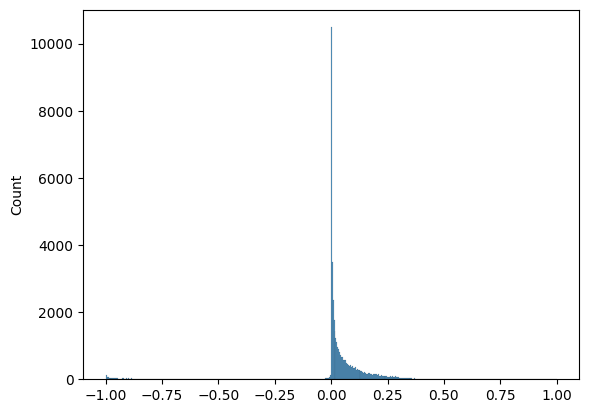

In [160]:
sns.histplot(residuals)
plt.show()

We have a right tail skew and a small bump between -0.75 and -1.0. Let's look at our correlation coefficients to see if we can be informed by them to reduce noise.

In [162]:
print(pd.DataFrame({
    'feature': df.columns,
    'coef': clf.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False))

                        feature          coef
34              total_rec_prncp  4.178596e-03
17                  funded_amnt -3.919945e-03
32                total_rec_int -2.153732e-03
4               total_pymnt_inv  1.530461e-03
5               funded_amnt_inv -1.446847e-03
20                   recoveries -1.287588e-03
2             settlement_amount -6.996584e-04
10                  installment -6.954983e-04
0                   total_pymnt  6.802308e-04
15           fund_amt_per_month -5.616476e-04
28         total_repayment_amnt -5.542515e-04
23                   revol_util  5.043356e-04
3                          term  4.478282e-04
30  diff_installment_last_pymnt -3.627818e-04
7               last_pymnt_amnt -3.327165e-04
13      collection_recovery_fee -2.013208e-04
31                    total_acc  1.277569e-04
14                          dti  1.273831e-04
24       mths_since_last_delinq  6.802377e-05
6                      int_rate  6.706443e-05
16               inq_last_6mths -6

All the coefficients are pretty small. This suggests that we may have features that need scaling. Also, we dropped quite a few categorical features--maybe left a lot of signal on the cutting room floor.

In [82]:
type(correlations)

pandas.core.series.Series

Featurize data and check target distribution again

In [ ]:
def prep_data(data):
  # Drop any features that have only 1 value
  for f in data.columns:
    if data[f].value_counts().shape[0] == 1:
      DROP.append(f)

  # and then a couple others that had very few classes or data was missing for the vast majority of instances
  DROP.extend(['tax_liens', 'delinq_amnt', 'settlement_date', 'debt_settlement_flag_date'])
  # and the ones that kinda give away the game
  # DROP.extend(['recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp'])
  # and one that doesn't really make sense -- next payment date not relevant
  DROP.append('next_pymnt_d')
  # and then dates for now because they present an interpolation problem I'll have to come back to
  DROP.extend(['last_credit_pull_d', 'last_pymnt_d', 'earliest_cr_line', 'issue_d'])

  DROP.extend([
    'sub_grade',
    'emp_title',
    'issue_d',
    'title',
    'zip_code',
    'addr_state',
    'settlement_status'
  ])

  coefs_0 = [0,
    'int_rate',
    'educational',
    '7 years',
    'pub_rec',
    'NONE',
    'grade',
    'moving',
    '6 years',
    'inq_last_6mths',
    'renewable_energy',
    'debt_consolidation',
    'revol_bal',
    'acc_now_delinq',
    'home_improvement',
    'house',
    'major_purchase',
    'annual_inc',
    'Source Verified',
    '5 years',
    '8 years',
    'wedding',
    'credit_card',
    '9 years',
    'loan_amnt',
    'settlement_term',
    'RENT',
    'medical',
    'small_business',
    '10+ years',
    'car',
    'funded_amnt_inv',
    '< 1 year',
    '4 years',
    'debt_settlement_flag',
    'OWN',
    'Verified',
    'other',
    'MORTGAGE',
    '2 years',
    'OTHER',
    'Not Verified',
    'delinq_2yrs',
    '3 years',
    'pub_rec_bankruptcies',
    '1 year',
    'vacation'
  ]

  DROP.extend(coefs_0)

  return data.loc[:,list(set(data.columns) - set(DROP))]

In [ ]:
DROP = list()
